# Extract patches

In [179]:
import numpy as np 
#import SlideRunner.general.dependencies
from SlideRunner.dataAccess.database import Database
from SlideRunner.dataAccess.annotations import *
import os
import openslide
import sqlite3
import cv2
import sys

# Get annotation images for all three databases and train/test splits

## Setup

Create directories for all three databases
* MEL, ODAEL, CODAEL
* Each database has three different train/test splits
* So there will be 9 total directories created

In [192]:
# make list of tuples
databases = ['MEL','ODAEL','CODAEL']
splits = ['1','2','3']

dir_names = []
for database in databases:
    for split in splits:
        dir_names.append((database, split))

# create the directories in current working directory
for database, split in dir_names:
    os.system('mkdir -p Data_CMC_%s_%s' % (database, split))

    dirs = ['Mitosis', 'Nonmitosis']
    for k in dirs:
        os.system('mkdir -p Data_CMC_%s_%s/train/%s' % (database,split,k))
        os.system('mkdir -p Data_CMC_%s_%s/test/%s' % (database,split,k))


Define database file paths

In [197]:
# path to directory main folder
path = '../../'
# list of databases
DBs = [path+'databases/MITOS_WSI_CMC_MEL.sqlite', 
path+'databases/MITOS_WSI_CMC_ODAEL_TR.sqlite', 
path+'databases/MITOS_WSI_CMC_CODAEL_TR_ROI.sqlite']
# make tuple with corresponding database label
databases = ['MEL','ODAEL','CODAEL']
DB_names = []
for i in range(len(DBs)):
    DB_names.append((DBs[i], databases[i]))


Define the test sets

In [182]:
slidelist_test_1 = ['18','3', '22','10','15','21','14']
slidelist_test_2 = ['1', '20','17','5', '2', '11','16']
slidelist_test_3 = ['12','13','7', '19','8', '6', '9']

test_slides = { '1': slidelist_test_1,
                '2': slidelist_test_2,
                '3': slidelist_test_3}

Set parameters
* Ensure WSIpath and basepath are setup properly according to your setup

In [183]:
disagreedclass = 0
agreedclass = 0
 # path to WSI folder
WSIpath='../../WSI/'
# absolute path to current working directory
basepath = '/Users/gsowell/Desktop/Research/Fourthbrain/fourthbrain/samsung-capstone/assignments/week-7-initial-github/'
patchSize=128

List of slides function

In [184]:
def listOfSlides(DB):
    DB.execute('SELECT uid,filename from Slides')
    return DB.fetchall()

**WARNING:** Takes a long time to run and will consume ~ 20 GBs of memory on local storage

Get image patches for every annotation in each database and assign it to the correct directory

In [202]:
# outer for loop to go through each database
for database, name in DB_names:
    # instantiate database object and open database
    DB = Database().open(database)

    # first inner for loop to go through slides of DB
    for slideid,filename in listOfSlides(DB):
        # load slide into memoetry and open w/openslide
        DB.loadIntoMemory(slideid)
    
        slide=openslide.open_slide(WSIpath+filename)

        # second inner for loop to go through each annotation on the current slide
        for k in DB.annotations.keys():

            anno = DB.annotations[k]

            if anno.deleted or anno.annotationType != AnnotationType.SPOT:
                continue
            coord_x = anno.x1
            coord_y = anno.y1

            lu_x = int(coord_x - int(patchSize/2))
            lu_y = int(coord_y - int(patchSize/2))
            img = np.array(slide.read_region(location=(lu_x, lu_y), level=0, size=(patchSize, patchSize)))
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
            
            # third inner for loop to assign annotation/image to proper directory of current database
            for split in splits:
                istest = 'train/' if str(slideid) not in test_slides[split] else 'test/'
                if (anno.agreedClass ==2):
                    cv2.imwrite(basepath+'Data_CMC_%s_%s/' % (name, split) +istest+'Mitosis/%d.png' % k, img)
                    #os.system(f'ln -s ../../../images/Mitosis/{k}.png Data_CMC{sys.argv[1]}/'+istest+'Mitosis/%d.png' %k)

                if (anno.agreedClass==1):
                    cv2.imwrite(basepath+'Data_CMC_%s_%s/' % (name, split) +istest+'Nonmitosis/%d.png' % k, img)
                    #os.system(f'ln -s ../../../images/Nonmitosis/{k}.png Data_CMC{sys.argv[1]}/'+istest+'Nonmitosis/%d.png' %k)
        print('Done with slide {} in database {}'.format(slideid, name))


Done with slide 1 in database CODAEL
Done with slide 2 in database CODAEL
Done with slide 3 in database CODAEL
Done with slide 5 in database CODAEL
Done with slide 6 in database CODAEL
Done with slide 7 in database CODAEL
Done with slide 8 in database CODAEL
Done with slide 9 in database CODAEL
Done with slide 10 in database CODAEL
Done with slide 11 in database CODAEL
Done with slide 12 in database CODAEL
Done with slide 13 in database CODAEL
Done with slide 14 in database CODAEL
Done with slide 15 in database CODAEL
Done with slide 16 in database CODAEL
Done with slide 17 in database CODAEL
Done with slide 18 in database CODAEL
Done with slide 19 in database CODAEL
Done with slide 20 in database CODAEL
Done with slide 21 in database CODAEL
Done with slide 22 in database CODAEL


# Test script looking at one annotation (MEL) on one slide only

## Load database

Instatiate database object

In [2]:
DB = Database()

Create viewing profile

In [4]:
vp = ViewingProfile()
vp.majorityClassVote=True

cm=np.zeros((7,7))
if len(sys.argv)<2:
    print('Synopsis: ',sys.argv[0],'<valrun>')
    sys.exit()
threshold = 5

In [27]:
type(sys.argv[1])

str

Set paths and parameters

In [29]:
disagreedclass = 0
agreedclass = 0
basepath='../../WSI/'
patchSize=128
dataset_name = 'MEL'

Create Data_CMC directory for the dataset_name defined above

In [33]:
os.system('mkdir -p Data_CMC_%s' % dataset_name)

dirs = ['Mitosis', 'Nonmitosis']
for k in dirs:
    os.system('mkdir -p Data_CMC_%s/train/%s' % (dataset_name,k))
    os.system('mkdir -p Data_CMC_%s/test/%s' % (dataset_name,k))

Get list of slides function

In [34]:
def listOfSlides(DB):
    DB.execute('SELECT uid,filename from Slides')
    return DB.fetchall()

Define the test set(s)

In [35]:
slidelist_test_1 = ['18','3', '22','10','15','21','14']
slidelist_test_2 = ['1', '20','17','5', '2', '11','16']
slidelist_test_3 = ['12','13','7', '19','8', '6', '9']

test_slides = { '1': slidelist_test_1,
                '2': slidelist_test_2,
                '3': slidelist_test_3}

Load database (according to dataset_name)

In [38]:
DB.open('../../databases/MITOS_WSI_CMC_MEL.sqlite')

Get list of slide IDs and filenames

In [39]:
listOfSlides(DB)

[(1, 'a8773be388e12df89edd.svs'),
 (2, '460906c0b1fe17ea5354.svs'),
 (3, '2d56d1902ca533a5b509.svs'),
 (5, 'd0423ef9a648bb66a763.svs'),
 (6, '50cf88e9a33df0c0c8f9.svs'),
 (7, 'da18e7b9846e9d38034c.svs'),
 (8, 'd7a8af121d7d4f3fbf01.svs'),
 (9, '2191a7aa287ce1d5dbc0.svs'),
 (10, '69a02453620ade0edefd.svs'),
 (11, 'c4b95da36e32993289cb.svs'),
 (12, 'fa4959e484beec77543b.svs'),
 (13, '72c93e042d0171a61012.svs'),
 (14, '4eee7b944ad5e46c60ce.svs'),
 (15, 'b1bdee8e5e3372174619.svs'),
 (16, '3d3d04eca056556b0b26.svs'),
 (17, '084383c18b9060880e82.svs'),
 (18, 'e09512d530d933e436d5.svs'),
 (19, 'd37ab62158945f22deed.svs'),
 (20, 'deb768e5efb9d1dcbc13.svs'),
 (21, '022857018aa597374b6c.svs'),
 (22, '13528f1921d4f1f15511.svs')]

Let's look at slide ID 16

In [40]:
slideid, filename = (16, '3d3d04eca056556b0b26.svs')

Load slideid into memory and instantiate slide

In [43]:
DB.loadIntoMemory(slideid)

slide=openslide.open_slide(basepath+filename)

Let's just look at the annotation 20970 (just the one I happened to be looking at in Slide Runner)

Get annotation coordinates

In [100]:
k = 20970
anno = DB.annotations[k]

coord_x = anno.x1
coord_y = anno.y1
lu_x = int(coord_x - int(patchSize/2))
lu_y = int(coord_y - int(patchSize/2))

In [101]:
print('The annotation class is:', anno.agreedClass)
print('Coordinates of absolute center of annotation:', (coord_x, coord_y))
print('Coordinates of upper left pixel in level 0:', (lu_x, lu_y))

The annotation class is: 2
Coordinates of absolute center of annotation: (49060, 41779)
Coordinates of upper left pixel in level 0: (48996, 41715)


Look at the images before and after changing the color scheme

In [102]:
img = np.array(slide.read_region(location=(lu_x, lu_y), level=0, size=(patchSize, patchSize)))

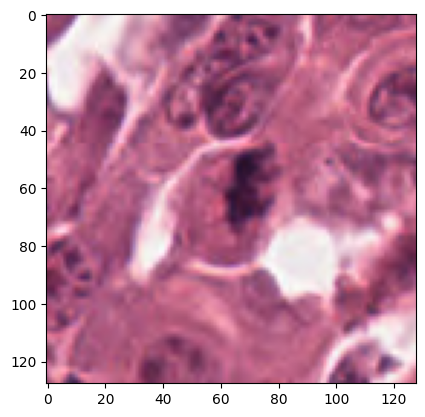

In [103]:
import matplotlib.pyplot as plt
plt.imshow(img)

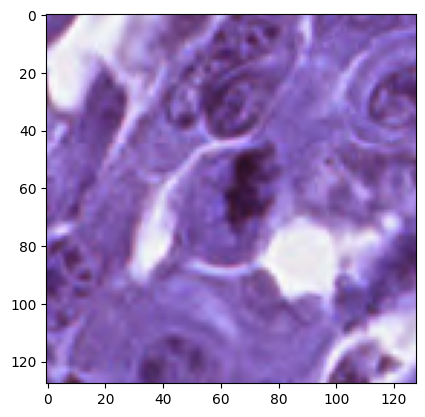

In [87]:
img2 = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
plt.imshow(img2)

In [152]:
k = 20970

Write png directly to the directory we created earlier based on whether slide is part of train or test set and if agreed class is Mitosis (2) or Nonmitosis (1)

In [157]:
istest = 'train/' if str(slideid) not in test_slides['1'] else 'test/'
if (anno.agreedClass ==2):
    cv2.imwrite('/Users/gsowell/Desktop/Research/Fourthbrain/fourthbrain/samsung-capstone/assignments/week-7-initial-github/Data_CMC_MEL/'+istest+'Mitosis/%d.png' % k, img)
    #os.system(f'ln -s ../../../images/Mitosis/{k}.png Data_CMC_{dataset_name}/'+istest+'Mitosis/%d.png' %k)

if (anno.agreedClass==1):
    cv2.imwrite('/Users/gsowell/Desktop/Research/Fourthbrain/fourthbrain/samsung-capstone/assignments/week-7-initial-github/Data_CMC_MEL/'+istest+'Nonmitosis/%d.png' % k, img)
    #os.system(f'ln -s ../../../images/Nonmitosis/{k}.png Data_CMC_{dataset_name}/'+istest+'Nonmitosis/%d.png' %k)

In [99]:
test_slides['1']

['18', '3', '22', '10', '15', '21', '14']